# Tutorial 06


In [75]:
from lanczos import *
import numpy as np
import functools
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [2]:
L = 14
g = 1.5

sx_list = gen_sx_list(L)
sz_list = gen_sz_list(L)

H = gen_hamiltonian(sx_list, sz_list, g)


In [15]:
E, vecs = scipy.sparse.linalg.eigsh(H, which='SA')
psi0 = vecs[:, 0]
print(psi0.shape)
psi_rand = np.random.normal(size=psi0.shape) + 1.j * np.random.normal(size=psi0.shape)
psi_rand /= np.linalg.norm(psi_rand)

(16384,)


In [16]:
T, B = lanczos(psi_rand, H, N=200, stabilize=False)
Es =np.linalg.eigvalsh(T)

In [17]:
print("Results with stabilize = False")
print("10 lowest Eigenvalues\n" , Es[:10])
print("10 lowest Eigenvalues\n" , E[:10])

10 lowest Eigenvalues
 [-23.40758298 -23.40758298 -23.40758298 -22.40634977 -22.40634977
 -22.40563963 -21.92703453 -21.92703453 -21.12647356 -21.12647356]
10 lowest Eigenvalues
 [-23.40758298 -22.40634977 -21.92703453 -21.92703453 -21.12647356
 -21.05728137]


We find a degernacy of 3.


In [21]:
T, B = lanczos(psi_rand, H, N=200, stabilize=True)
Es_stb =np.linalg.eigvalsh(T)

In [22]:
print("Results with stabilize = True")
print("10 lowest Eigenvalues\n" , Es_stb[:10])

Results with stabilize = True
10 lowest Eigenvalues
 [-23.40758298 -22.40634977 -21.92703453 -21.92703453 -21.12647356
 -21.05728137 -21.05728137 -20.36491833 -20.36491833 -20.19235712]


In [51]:
#c)
w, vs = np.linalg.eigh(T)
U_0 = vs[:,0]
psi0_c = np.array(B).T @ U_0
psi0_c /= np.linalg.norm(psi0_c)

# energy
energy = np.inner(psi0_c.conj(), (H @ psi0_c)).real
print("Former energy: {}, this energy: {}".format(Es[0], energy))

# variance
variance = (np.inner(psi0_c.conj(), (H @ H @ psi0_c)) - energy**2).real
print("Variance {}".format(variance))

Former energy: -23.40758298202162, this energy: -23.407582982021665
Variance -2.0463630789890885e-12


In [56]:
#d)
Splus_0 = singesite_to_full(Splus, 0, L)
phi0 = Splus_0 @ psi0_c

Tphi, Bphi = lanczos(phi0, H, N=200, stabilize=True)

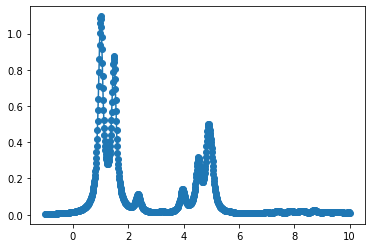

In [73]:

def  recurssion_wrapper(z, T, L):
    count = 0
    fraction = T[-2, -1]**2 / (z - T[-1, -1])

    while count < len(T)-2:
        fraction = 1/(z-T[-count-3,-count-3]-T[-count-3, -count-2]**2*fraction)
        count += 1

    return -fraction.imag/np.pi

epsilon = .1
omegas = np.linspace(-1,10, 1000)
E0 = Es_stb[0]
z = omegas + E0 + epsilon*1j
I = recurssion_wrapper(z, Tphi, L)

# plot

plt.plot(omegas, I, '-o')
plt.show()



100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


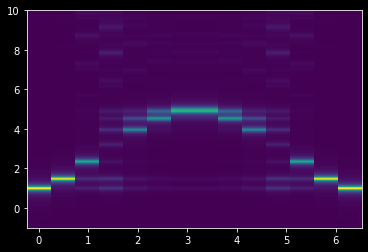

In [77]:
# g)
ks= np.linspace(0, L, L) * np.pi * 2 / L
Splus_ks = []

for k in ks:
    sum = 0
    for j in range(L):
        sum += np.exp(1j * j * k) * singesite_to_full(Splus, j, L)

    Splus_ks.append(1 / np.sqrt(L) * sum)

Splus_ks = np.array(Splus_ks)

# make plot
epsilon = .1
omegas = np.linspace(-1,10, 1000)
z = omegas + E0 + epsilon*1j
E0 = Es_stb[0]

Is=[]

for Splus_k in tqdm(Splus_ks):
    phik = Splus_k @ psi0_c
    Tphi, Bphi = lanczos(phik, H, N=200, stabilize=True)

    I = recurssion_wrapper(z, Tphi, L)
    Is.append(I)

colorplot(ks, omegas, Is)

In [101]:
# h)
epsilon = .1
omegas = np.linspace(-1,10, 1000)
ks= np.linspace(-L/2, L/2, L) * np.pi * 2 / L

Splus_ks = []

for k in ks:
    sum = 0
    for j in range(L):
        sum += np.exp(1j * j * k) * singesite_to_full(Splus, j, L)

    Splus_ks.append(1 / np.sqrt(L) * sum)

Splus_ks = np.array(Splus_ks)

100%|██████████| 14/14 [00:25<00:00,  1.82s/it]


14 1000 (14, 1000)
14 1000 (14, 1000)
14 1000 (14, 1000)
14 1000 (14, 1000)
14 1000 (14, 1000)
14 1000 (14, 1000)


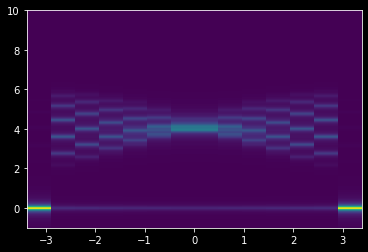

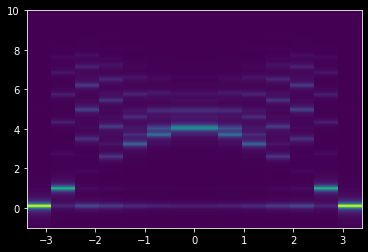

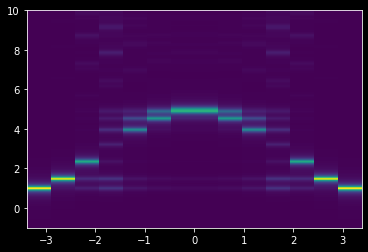

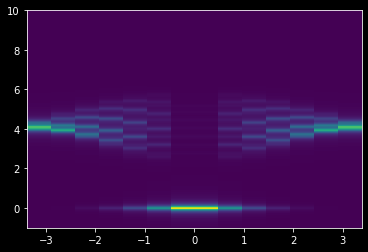

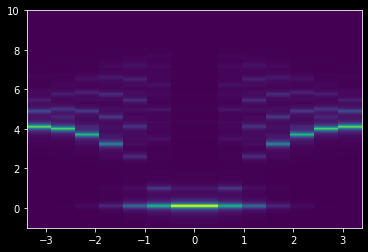

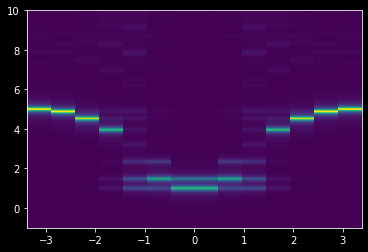

In [102]:

for J in [-1,1]:
    for g in [0.5,1,1.5]:
        H = gen_hamiltonian(sx_list, sz_list, g, J=J)
        E0, vecs = scipy.sparse.linalg.eigsh(H, which='SA')
        psi0 = vecs[:, 0]
        z = omegas + E0[0] + epsilon*1j

        Is = []
        for Splus_k in tqdm(Splus_ks):
            phik = Splus_k @ psi0
            Tphi, Bphi = lanczos(phik, H, N=200, stabilize=True)

            I = recurssion_wrapper(z, Tphi, L)
            Is.append(I)

        print(len(ks), len(omegas), np.array(Is).shape)
        plt.figure()
        colorplot(ks, omegas, Is)